In [1]:
# This Pandas script conducts an analysis of weather related info to provide insights into weather patterns
#   as one moves from the ploes towards the equator.
#
# The results of this analysis are displayed using a number of plots that depict temprature, humidity, wind speed
#   abd cloudiness, as a function of latitude.
#
# The high level logic is as follows:
#   1. Start with selecting a random sample of at least 500 cities around the globe;
#   2. Retireve current weather conditions for each of these cities; and
#   3. Generate various graphs mentioedn above.
#
# Various code blocks below provide additional details.
#

# Observations
1. Temperatures across the globe gradually increase as one moves from the poles towards the equator.
    - See the second graph below - Max Daily Temperature in Selected World Cities. 
    - This scatter plot is skewed due to seasonal effects:
        - Higher temeperatures in the southern hemisphere where it's currently summer.
        - Lower temperatures in the northern hemisphere where it is winter.
2. There is no discernable relationship between humidity, wind speed and cloudiness, as a function of latitude.
    - Humidity, wind speed and cloundiness all seem to be evenly distributed across all latitudes.
    - There are likely other local effects, such as storms, which have a bigger effect.
3. This analysis is based on current weather conditions and susceptible to seasonal and other conditions such as time of day or storms.
    - One way to reduce the effects of seasonality and local conditions is to analyze annual data for each city.

In [2]:
# Import various dependencies
import pandas as pd
import matplotlib.pyplot as plt
import requests as req
import numpy as np
from citipy import citipy as cp

In [3]:
# This code block produces a random list of cities around the world and stores the result in a dictionary called city_list.
#
# This city list is generated a function in citipy module called nearest_city().
# This function accepts two parameters: latitude and longitude.
#
# The general algorithm is to utilize a nested pair of for loops which iterate over all latitudes and longitudes.
# Since there are almost 8,000 cities in the database used by citipy, one needs to randomize the selection of latitude
#   and longitude numbers when invoking nearest_city().  At the same time, we need to ensure an even selection of latitudes
#   from the poles to the equator.
# To achieve both these goals, the outer for loop iterates over all latitudes from the south pole (-90) to the north (90).
#
# Finally, to throttle calls to the database of worldwide cities, a while loop is used to control the overall execution.
# Note that the chosen threshold is well above 500; this is due to issues that arise in using the openweather API; see the
#   comments in the next code blocks for details.
#
# Initialize a couple of variable, which track the number of cities and store the list of selected cities.
city_count = 0
city_list = {}         # dictionary of selected cities; key city name, value is latitude and longitude
while city_count<600:  # This outer loop throttles the calls to nearest_city by keeping track of the number of selected cities
    for x in range(-90,90,3):          # start iterating over all latitudes between -90 and 90, in increments of 3 degrees
        if city_count > 600: continue  # check to see if we have selected enough cities, and bail if so
        # This loop covers valrious longitudes across the globe. In order to minimize over selecting cities in the southern
        #    hemisphere, we select 9 random longitudes at each iteration.
        for y in np.random.uniform(-180,180,9):
            if city_count > 600: continue # again, check to see if we have selected enough cities, and bail if so
            city = cp.nearest_city(x,y)   # invoke nearest_city() to get the next city candidate
            if city.city_name in city_list: continue # check to see if we've already selected the candidate city; skip it if so
            city_count+=1                 # Otherwise, increment the count and add the new city to the dictionary/list.
            city_list[city.city_name] = {'lat':x, 'lng':y}

In [4]:
# This code block retrieves weather information for each selected city, from the openweather end point service.
#
api_key = "42e65c9cf47bbb2b64889fbecce13f1b"
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "metric"
# Build partial query URL
query_url = url + "appid=" + api_key + "&units=" + units + "&q="
# List used to store responses returned by the openweather service; note that due to throttling imposed by the server, some
#    responses do not containg actual weather related info; more on this in the next code block.
weather_data = []
for city in city_list:                           # For all the cities in the list of selected cities,
    response = req.get(query_url + city).json()  #   send a query to the openweather server
    weather_data.append(response)                #   and add the returned data to the list, for further processing

In [17]:
# This code block converts weather related info, stored in the list defined in the previous block, to a data frame
#    for subsequent plotting.
#
# Start with declaring a number of lists which will contain various pieces of info retireved from openweather.
lats = []      # this list will contain the latitude for each selected city
lons = []      # this list will contain the longitude for each selected city
temps = []     # this list contains the temperature for each selected city
humidity = []  # this list contains the humity for each selected city
winds = []     # this list contains the wind speed for each selected city
clouds = []    # this list contains cloudiness for each selected city
names = []     # this list contains the name of each selected city
# Iterating over all the records returned by openweather server,
for data in weather_data:
    try:       # Extract latitude, longitude, temperature, humity, cloudiness, wind speed and the name
               # from each record, and store these data in various lists using list comprehension
               # Note that some records do not contain weather related info due to throttling imposed by openweather server;
               #   as such, list comprehension cannot be used
        lats.append(data['coord']['lat'])
        lons.append(data['coord']['lon'])
        temps.append(data['main']['temp_max'])
        humidity.append(data['main']['humidity'])
        winds.append(data['wind']['speed'])
        clouds.append(data['clouds']['all'])
        names.append(data['name'])
    except:
        continue # skip over records which do not contain weather related info

#Now combines all the lists into a single data frame for subsequnet plotting
global_data = {'Temp': temps, 'Lat': lats, 'Lon':lons, 'Humidity':humidity, 'Wind':winds, 'Cloudiness':clouds, 'Name':names}
global_data = pd.DataFrame(global_data)
global_data.head()  # print the first five records of the resulting data frame
global_data.to_csv('weather_info.csv') # store the resulting data frame in a CSV file

In [18]:
print (len(temps))  # print the length of temperatures list to make sure we have at least 500 data points

525


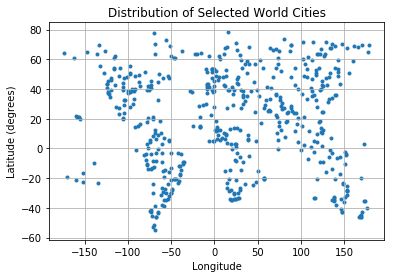

In [19]:
# This code block produces a scatter plot of the location of selected city, to visualize their locations across the globe.
# As expected, this plot outlines all the continents since most of the cities are within continents (with the exception of
#   island locations).  This graph shows that we have good coverage of cities in both southern and northern hemispheres.
plt.scatter(global_data["Lon"], global_data["Lat"], marker=".")
plt.title("Distribution of Selected World Cities")
plt.ylabel("Latitude (degrees)")
plt.xlabel("Longitude")
plt.grid(True)
plt.show()

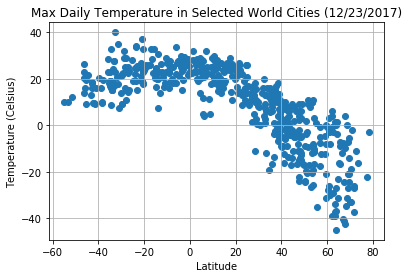

In [20]:
# This code block produces a scatter plot of temperature as a function of latitude
plt.scatter(global_data["Lat"], global_data["Temp"], marker="o")

# Incorporate the other graph properties
plt.title("Max Daily Temperature in Selected World Cities (12/23/2017)")
plt.ylabel("Temperature (Celsius)")
plt.xlabel("Latitude")
plt.grid(True)
# Save the figure
plt.savefig("TemperatureInWorldCities.png")
# Show plot
plt.show()

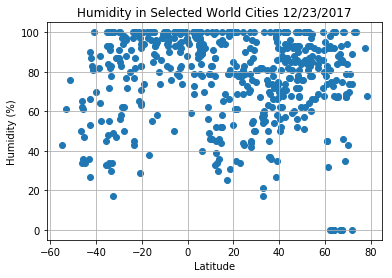

In [21]:
# This code block produces a scatter plot of humidity as a function of latitude
plt.scatter(global_data["Lat"], global_data["Humidity"], marker="o")
# Incorporate the other graph properties
plt.title("Humidity in Selected World Cities 12/23/2017")
plt.ylabel("Humidity (%)")
plt.xlabel("Latitude")
plt.grid(True)
# Save the figure
plt.savefig("HumidityInWorldCities.png")
# Show plot
plt.show()

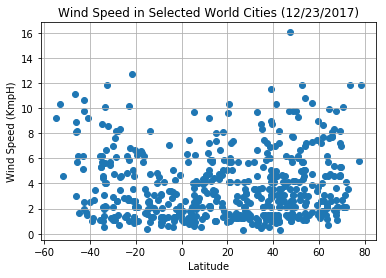

In [24]:
# This code block produces a scatter plot of wind speed as a function of latitude
plt.scatter(global_data["Lat"], global_data["Wind"], marker="o")
# Incorporate the other graph properties
plt.title("Wind Speed in Selected World Cities (12/23/2017)")
plt.ylabel("Wind Speed (KmpH)")
plt.xlabel("Latitude")
plt.grid(True)
# Save the figure
plt.savefig("WindSpeedInWorldCities.png")
# Show plot
plt.show()

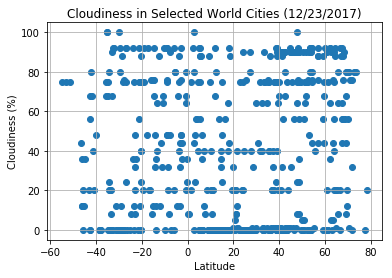

In [25]:
# This code block produces a scatter plot of cloudiness as a function of latitude
plt.scatter(global_data["Lat"], global_data["Cloudiness"], marker="o")
# Incorporate the other graph properties
plt.title("Cloudiness in Selected World Cities (12/23/2017)")
plt.ylabel("Cloudiness (%)")
plt.xlabel("Latitude")
plt.grid(True)
# Save the figure
plt.savefig("CloudinessInWorldCities.png")
# Show plot
plt.show()